In [43]:
import kagglehub
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0, DenseNet121

In [95]:
dataset = "tolgadincer/labeled-chest-xray-images"
path = "/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1"

if not os.path.exists(path):
    path = kagglehub.dataset_download(dataset)
    print("Path to dataset files:", path)

path = os.path.join(path, "chest_xray")
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

100%|██████████| 1.17G/1.17G [00:10<00:00, 123MB/s]Extracting files...

Path to dataset files: /root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (64, 64) 
EPOCHS = 10
RANDOM_SEED = 42

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  
    subset='training',
    seed=RANDOM_SEED,
    shuffle=True
)

Found 4187 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False 
)

Found 624 images belonging to 2 classes.


In [7]:
val_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=RANDOM_SEED
)

Found 1045 images belonging to 2 classes.


In [8]:
class_names = list(train_ds.class_indices.keys())

print(f"Classes: {class_names}")
print(f"Training samples: {train_ds.samples}")
print(f"Validation samples: {val_ds.samples}")
print(f"Test samples: {test_ds.samples}")

Classes: ['NORMAL', 'PNEUMONIA']
Training samples: 4187
Validation samples: 1045
Test samples: 624


In [9]:
def visualize_samples(dataset, num_samples=5, title="Sample Images"):
    """Visualize sample images from the dataset with proper normalization"""
    images, labels = next(dataset)
    plt.figure(figsize=(16, 4))
    
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i+1)
        
        plt.imshow(images[i])
        plt.title(f"{class_names[int(round(labels[i]))]}")
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

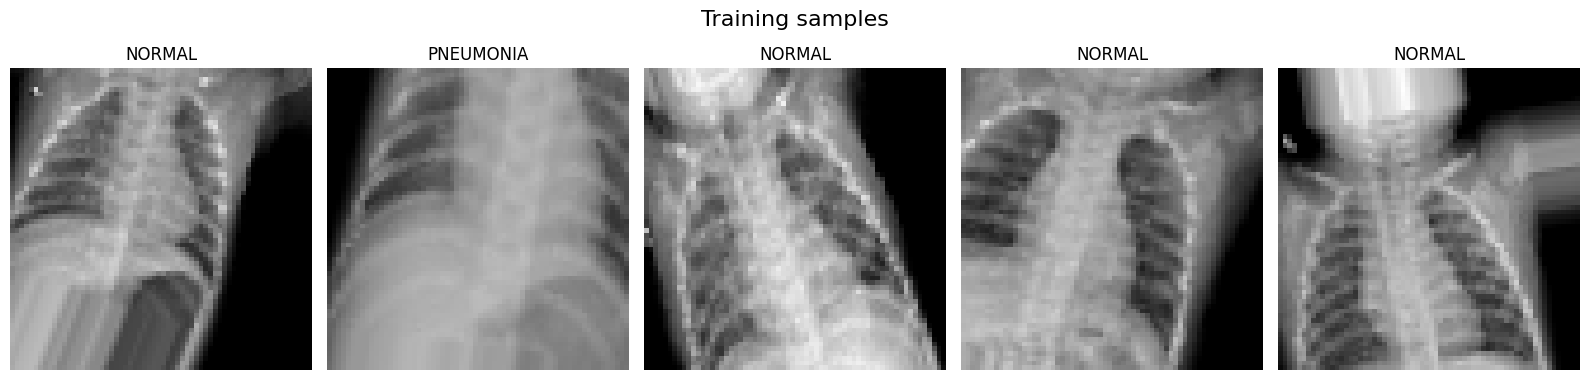

In [10]:
visualize_samples(train_ds, num_samples=5, title="Training samples")

In [11]:
def create_baseline_model(img_size):
    """Create a baseline CNN model"""
    input_shape = img_size + (3,)
    
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid') 
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

In [12]:
def create_transfer_model(img_size, base_model_name, trainable_layers=0):
    """Create a transfer learning model with specified base model and trainable layers"""
    input_shape = img_size + (3,)
    
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported model name: {base_model_name}")
    
    base_model.trainable = False
    
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(), 
        layers.Dense(512, activation='relu'), 
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid') 
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

In [13]:
train_labels = np.array(train_ds.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 1.938425925925926, 1: 0.6738010943031864}


In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [15]:
model_configs = [
    {'name': 'Baseline', 'trainable_layers': 0, 'is_baseline': True},
    {'name': 'ResNet50', 'trainable_layers': 0},
    {'name': 'ResNet50', 'trainable_layers': 10},
    {'name': 'EfficientNetB0', 'trainable_layers': 0},
    {'name': 'DenseNet121', 'trainable_layers': 0}
]

In [16]:
all_histories = []
all_models = []
model_names = []
evaluation_results = []

In [17]:
for config in model_configs:
    model_name = config.get('name')
    trainable = config.get('trainable_layers', 0)
    is_baseline = config.get('is_baseline', False)
    
    if is_baseline:
        model_name = 'Baseline_CNN'
        model = create_baseline_model(IMG_SIZE)
    else:
        model_name = f"{model_name}_trainable_{trainable}"
        model = create_transfer_model(IMG_SIZE, config['name'], trainable)
    
    print(f"\n{'='*70}\nTraining {model_name}\n{'='*70}")
    model.summary()
    
    checkpoint_path = f"{model_name}_best.h5"
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )
    
    all_histories.append(history)
    all_models.append(model)
    model_names.append(model_name)
    
    test_results = model.evaluate(test_ds, verbose=1)
    test_loss, test_accuracy, test_auc = test_results
    
    y_pred_prob = model.predict(test_ds)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = test_ds.classes
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    evaluation_results.append({
        'model': model_name,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc,
        'test_loss': test_loss,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'y_true': y_true,
        'y_pred': y_pred.flatten(),
        'y_pred_prob': y_pred_prob.flatten()
    })
    
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


Training Baseline_CNN
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (Non

In [18]:
eval_df = pd.DataFrame([
    {
        'model': result['model'],
        'accuracy': result['test_accuracy'],
        'auc': result['test_auc'],
        'loss': result['test_loss'],
        'combined_score': result['test_accuracy'] + result['test_auc'] - 0.1 * result['test_loss']
    } for result in evaluation_results
])

In [19]:
def plot_learning_curves(histories, model_names):
    """Plot learning curves with improved styling"""
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(histories)))
    
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0].plot(history.history['accuracy'], color=colors[i], label=f'{name} (Train)')
        axes[0].plot(history.history['val_accuracy'], color=colors[i], linestyle='--', 
                  label=f'{name} (Val)')
    
    axes[0].set_title('Model Accuracy', fontsize=16)
    axes[0].set_ylabel('Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[1].plot(history.history['loss'], color=colors[i], label=f'{name} (Train)')
        axes[1].plot(history.history['val_loss'], color=colors[i], linestyle='--',
                  label=f'{name} (Val)')
    
    axes[1].set_title('Model Loss', fontsize=16)
    axes[1].set_ylabel('Loss', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('improved_learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
def plot_roc_curves(evaluation_results):
    """Plot ROC curves with improved styling"""
    plt.figure(figsize=(12, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(evaluation_results)))
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, lw=2, label='Random (AUC = 0.500)')
    
    for i, result in enumerate(evaluation_results):
        plt.plot(result['fpr'], result['tpr'], color=colors[i], lw=2,
                 label=f"{result['model']} (AUC = {result['roc_auc']:.3f})")
    
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves Comparison', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.tight_layout()
    plt.savefig('improved_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
def plot_confusion_matrices(evaluation_results, class_names):
    """Plot confusion matrices with better styling"""
    n_models = len(evaluation_results)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, result in enumerate(evaluation_results):
        cm = confusion_matrix(result['y_true'], result['y_pred'])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                   xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                axes[i].text(k + 0.5, j + 0.7, f"{cm_normalized[j, k]:.1%}", 
                          ha="center", color="black" if cm[j,k] < cm.max() / 2 else "white")
        
        axes[i].set_title(f"Confusion Matrix: {result['model']}", fontsize=13)
        axes[i].set_xlabel('Predicted', fontsize=11)
        axes[i].set_ylabel('True', fontsize=11)
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.savefig('improved_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
def plot_model_comparison(eval_df):
    """Plot model comparison with improved styling"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    sorted_df = eval_df.sort_values('accuracy', ascending=False)
    
    sns.barplot(x='model', y='accuracy', data=sorted_df, ax=axes[0], palette='viridis')
    for i, v in enumerate(sorted_df['accuracy']):
        axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
    
    axes[0].set_title('Test Accuracy Comparison', fontsize=16)
    axes[0].set_ylabel('Accuracy', fontsize=14)
    axes[0].set_xlabel('')
    axes[0].set_ylim([0.5, 1.0])  # Better visibility of differences
    axes[0].grid(axis='y', alpha=0.3)
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    
    sns.barplot(x='model', y='auc', data=sorted_df, ax=axes[1], palette='plasma')
    for i, v in enumerate(sorted_df['auc']):
        axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
    
    axes[1].set_title('Test AUC Comparison', fontsize=16)
    axes[1].set_ylabel('AUC', fontsize=14)
    axes[1].set_xlabel('Model', fontsize=14)
    axes[1].set_ylim([0.5, 1.0])  
    axes[1].grid(axis='y', alpha=0.3)
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('improved_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
def visualize_predictions(model, dataset, num_samples=10):
    """Visualize model predictions with explanatory heatmaps"""

    batches = dataset.next()
    images = batches[0][:num_samples]
    true_labels = batches[1][:num_samples]
    
    predictions = model.predict(images)
    
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(images[i])
        
        pred_label = 'PNEUMONIA' if predictions[i] > 0.5 else 'NORMAL'
        true_label = 'PNEUMONIA' if true_labels[i] > 0.5 else 'NORMAL'
        
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({predictions[i][0]:.2f})", 
                  color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

In [24]:
def generate_summary_report(eval_df):
    """Generate and print a comprehensive summary report"""
    best_accuracy_model = eval_df.loc[eval_df['accuracy'].idxmax()]
    best_auc_model = eval_df.loc[eval_df['auc'].idxmax()]
    best_combined_model = eval_df.loc[eval_df['combined_score'].idxmax()]
    
    print("\n" + "="*70)
    print("IMPROVED CHEST X-RAY CLASSIFICATION SUMMARY REPORT")
    print("="*70)
    
    print("\nBest model by accuracy:")
    print(f"  Model: {best_accuracy_model['model']}")
    print(f"  Accuracy: {best_accuracy_model['accuracy']:.4f}")
    print(f"  AUC: {best_accuracy_model['auc']:.4f}")
    print(f"  Loss: {best_accuracy_model['loss']:.4f}")
    
    print("\nBest model by AUC:")
    print(f"  Model: {best_auc_model['model']}")
    print(f"  Accuracy: {best_auc_model['accuracy']:.4f}")
    print(f"  AUC: {best_auc_model['auc']:.4f}")
    print(f"  Loss: {best_auc_model['loss']:.4f}")
    
    print("\nBest model by combined score (accuracy + AUC - 0.1*loss):")
    print(f"  Model: {best_combined_model['model']}")
    print(f"  Accuracy: {best_combined_model['accuracy']:.4f}")
    print(f"  AUC: {best_combined_model['auc']:.4f}")
    print(f"  Loss: {best_combined_model['loss']:.4f}")
    print(f"  Combined Score: {best_combined_model['combined_score']:.4f}")
    
    print("\nAll Models ranked by combined score:")
    combined_ranked = eval_df.sort_values('combined_score', ascending=False)
    for i, (_, row) in enumerate(combined_ranked.iterrows(), 1):
        print(f"  {i}. {row['model']}: Accuracy={row['accuracy']:.4f}, AUC={row['auc']:.4f}, Combined={row['combined_score']:.4f}")
    
    print("\nFinal Recommendation:")
    print(f"  The recommended model is: {best_combined_model['model']}")
    print(f"  This model provides the best balance of accuracy and generalization performance.")
    print(f"  It correctly classifies {best_combined_model['accuracy']:.2%} of chest X-rays.")

In [25]:
best_model_idx = eval_df['combined_score'].idxmax()
best_model_name = eval_df.loc[best_model_idx, 'model']
best_model = all_models[model_names.index(best_model_name)]


Generating visualizations and analysis...


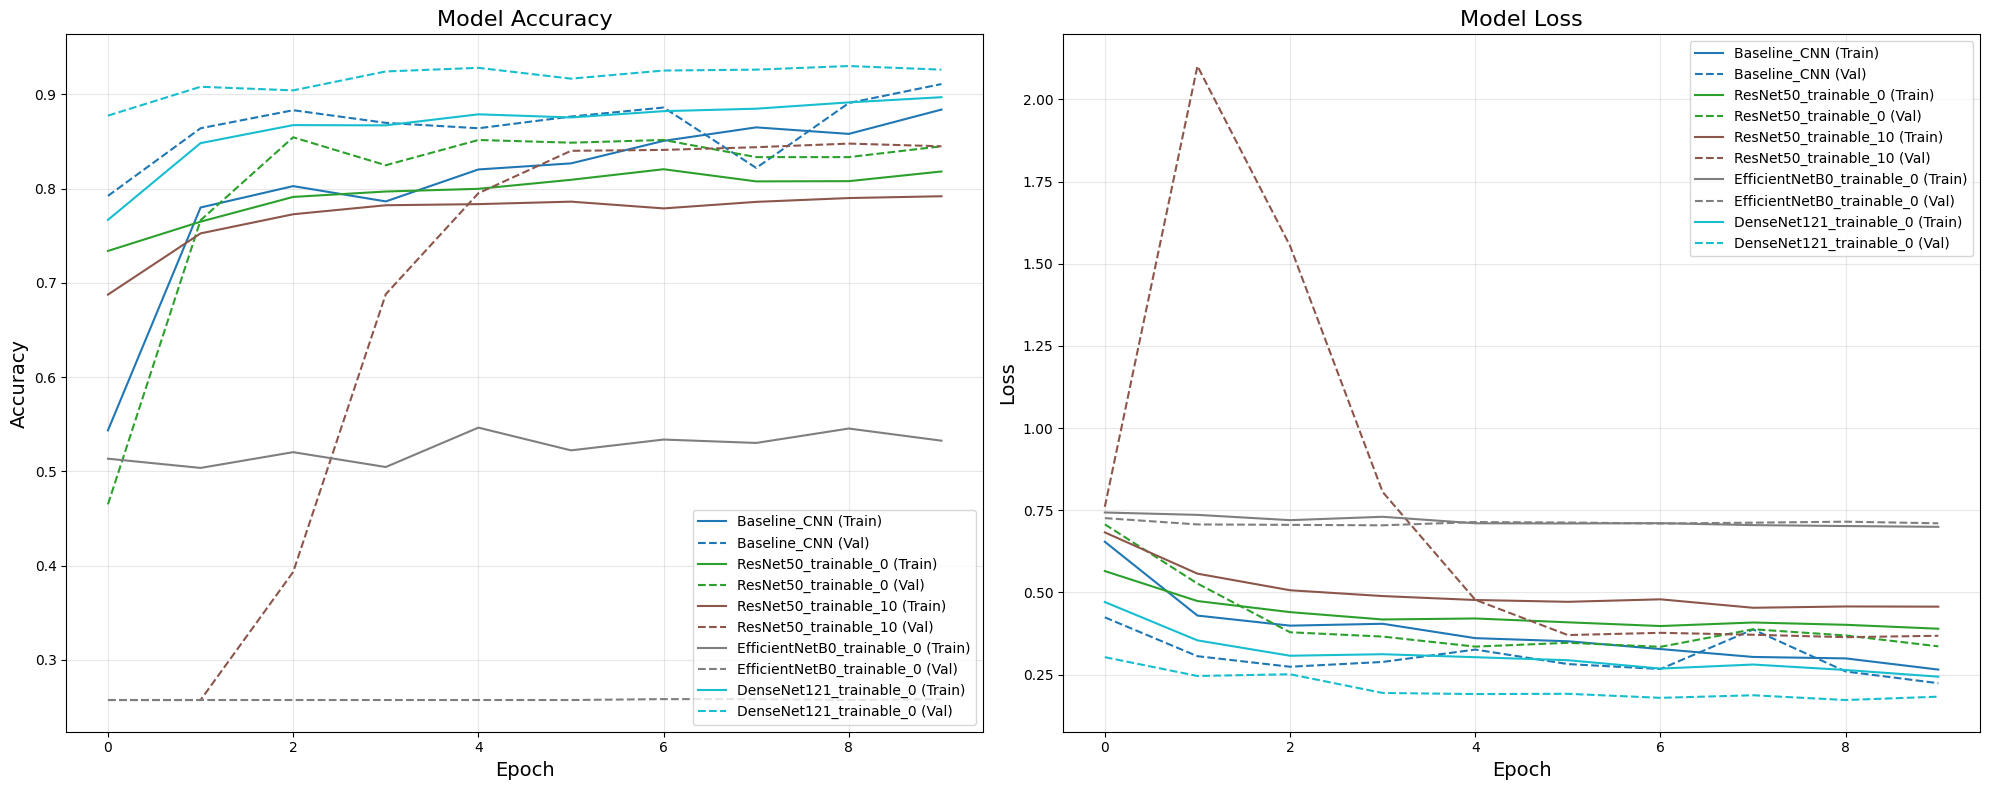

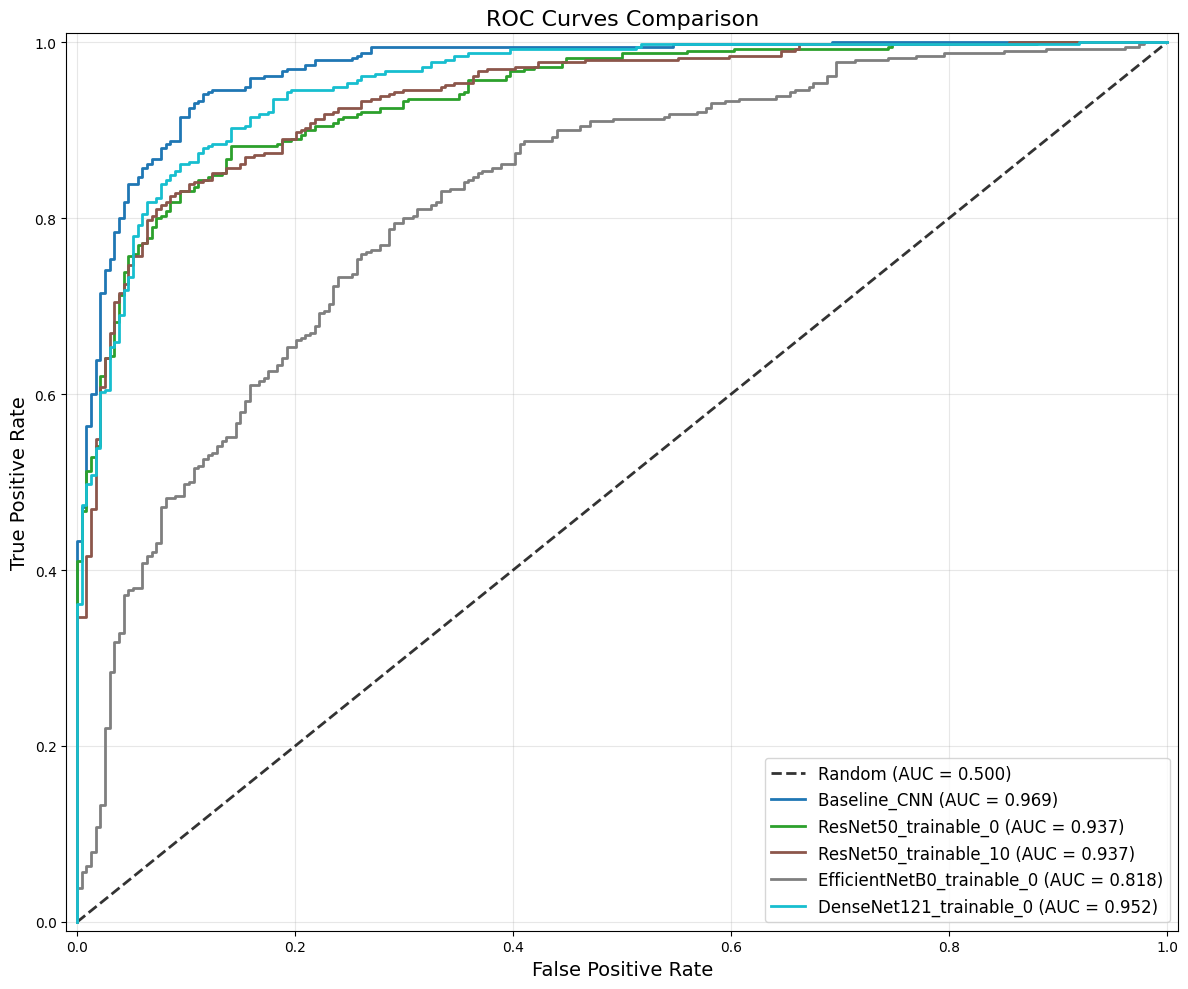

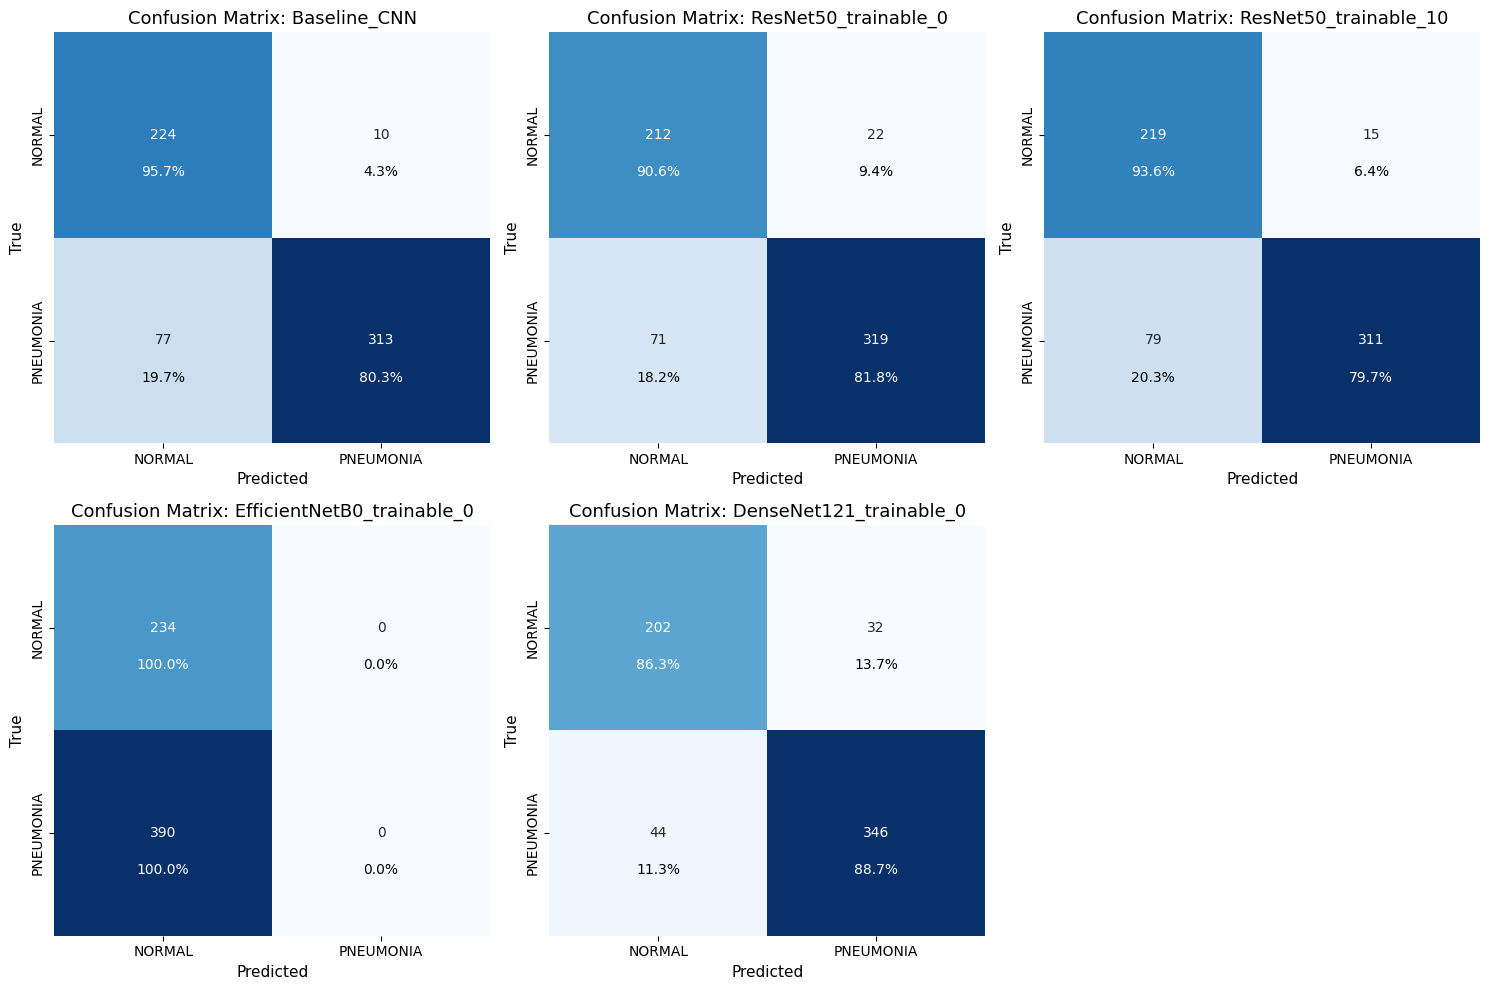

/tmp/ipykernel_40/1936353826.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='accuracy', data=sorted_df, ax=axes[0], palette='viridis')
/tmp/ipykernel_40/1936353826.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='auc', data=sorted_df, ax=axes[1], palette='plasma')


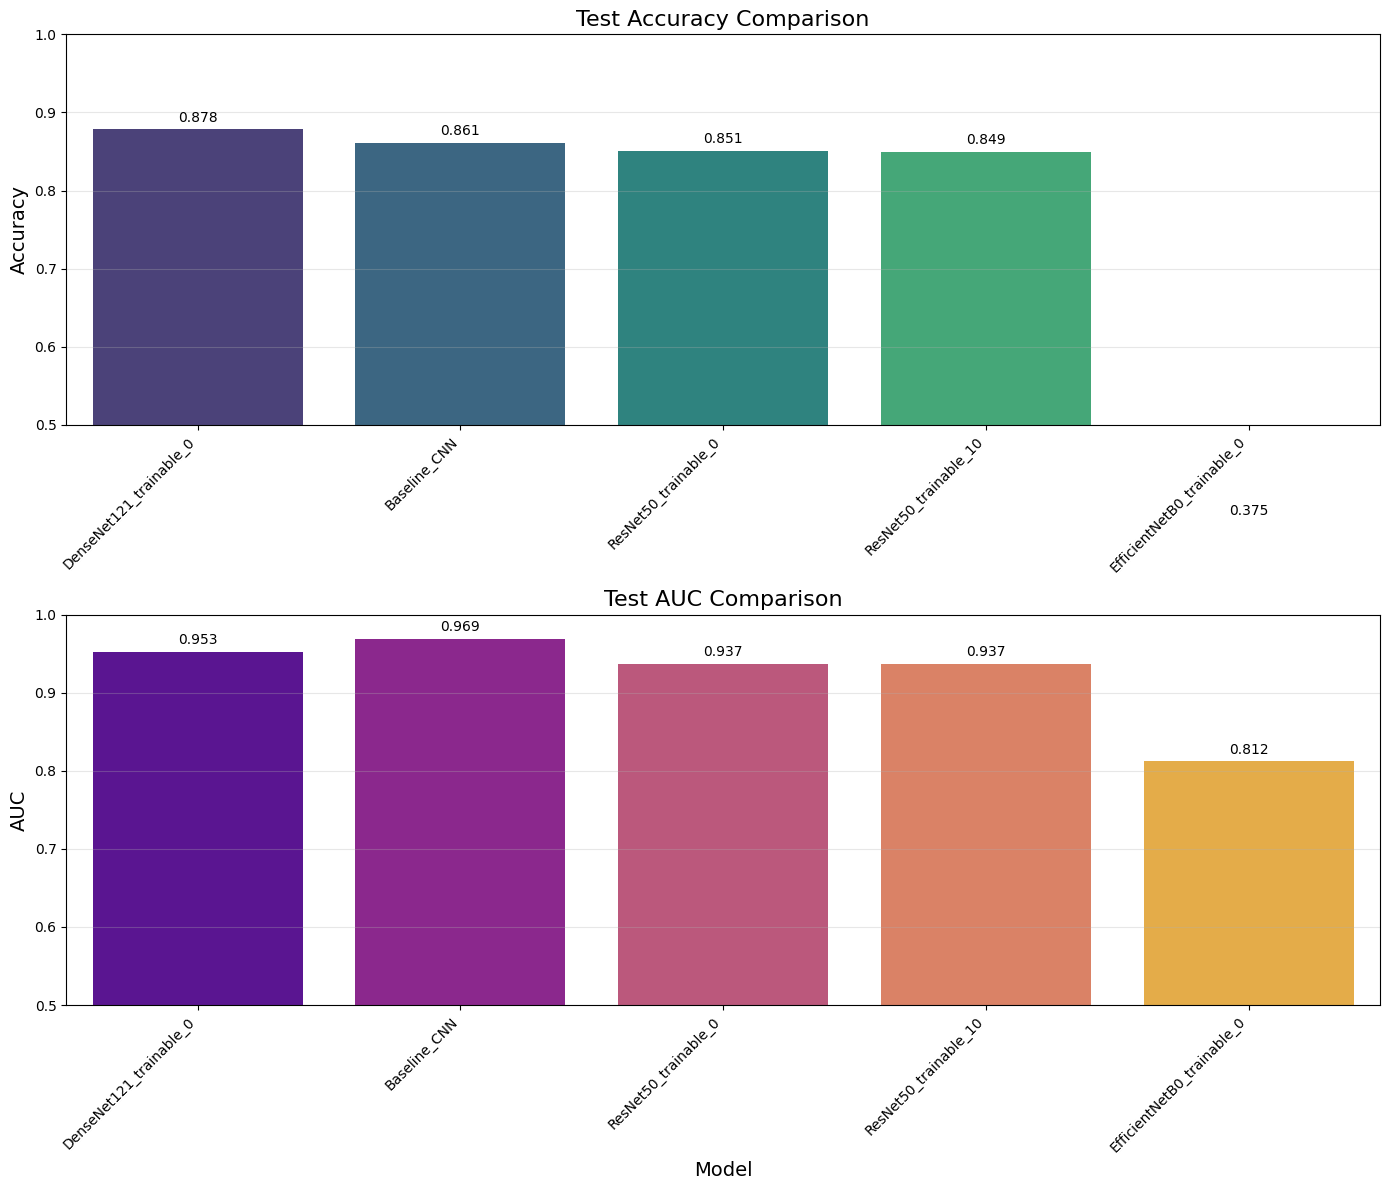

1/1 [==============================] - 2s 2s/step


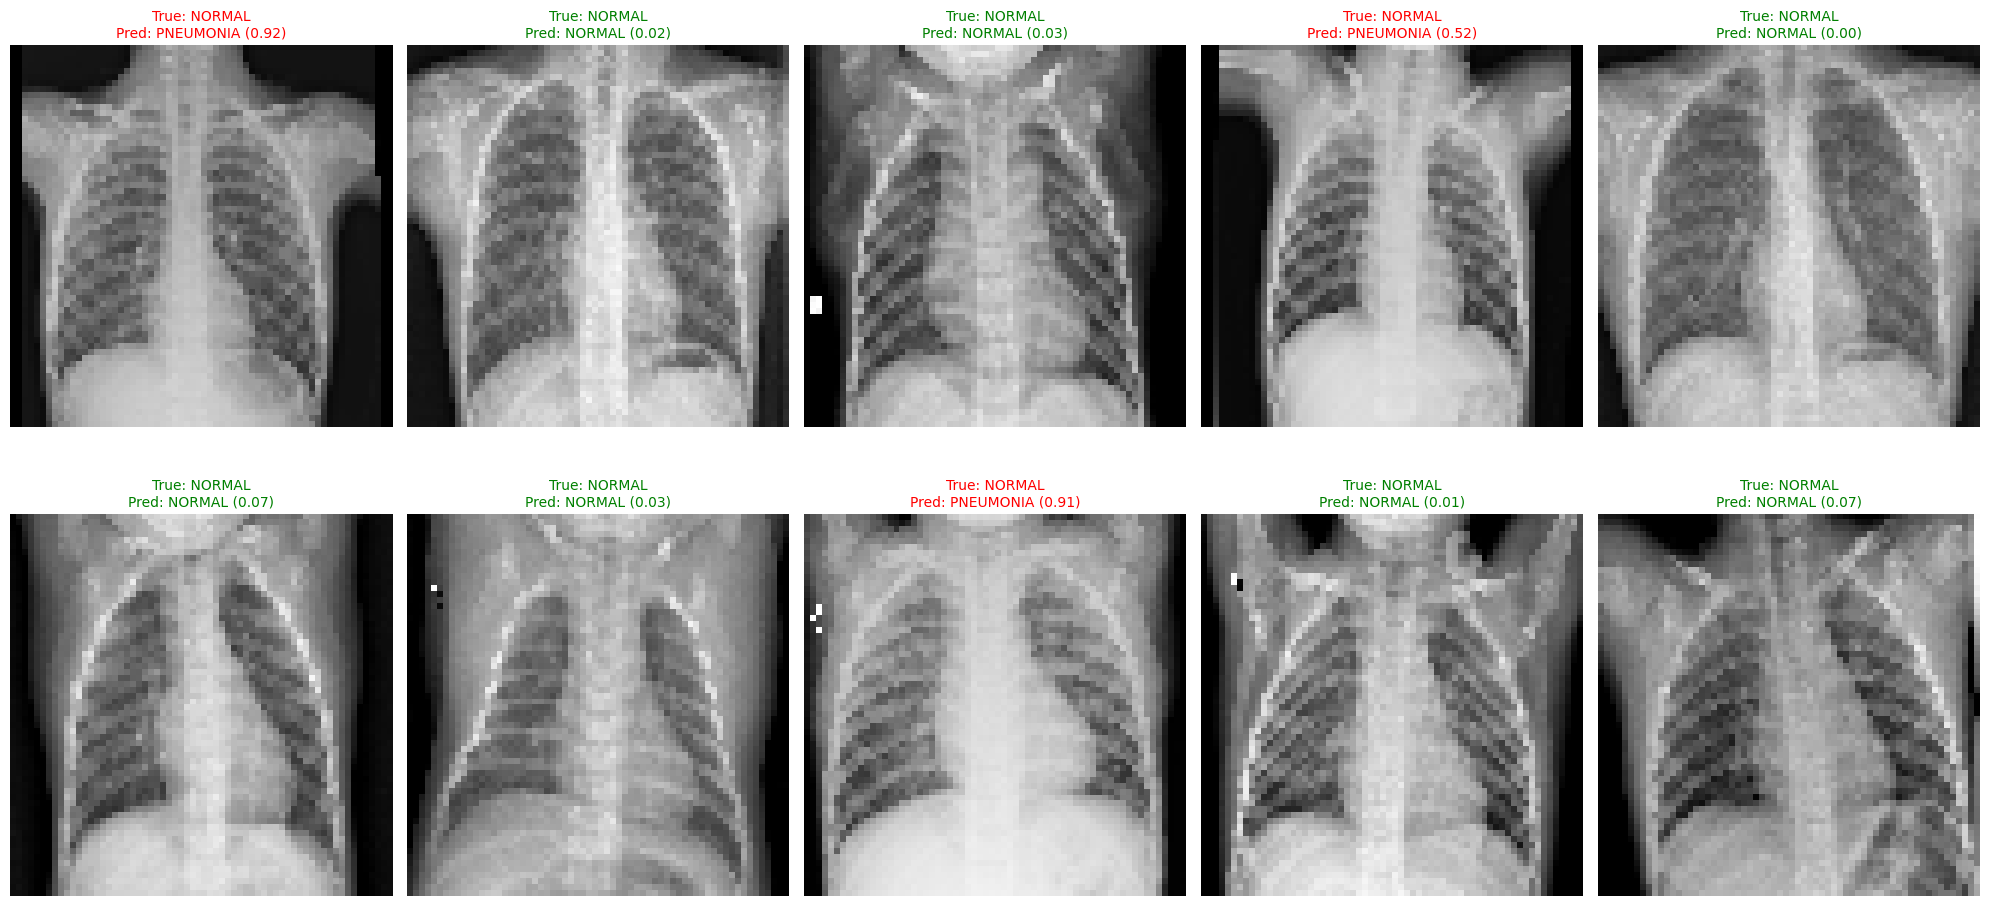


IMPROVED CHEST X-RAY CLASSIFICATION SUMMARY REPORT

Best model by accuracy:
  Model: DenseNet121_trainable_0
  Accuracy: 0.8782
  AUC: 0.9526
  Loss: 0.2750

Best model by AUC:
  Model: Baseline_CNN
  Accuracy: 0.8606
  AUC: 0.9690
  Loss: 0.3002

Best model by combined score (accuracy + AUC - 0.1*loss):
  Model: DenseNet121_trainable_0
  Accuracy: 0.8782
  AUC: 0.9526
  Loss: 0.2750
  Combined Score: 1.8033

All Models ranked by combined score:
  1. DenseNet121_trainable_0: Accuracy=0.8782, AUC=0.9526, Combined=1.8033
  2. Baseline_CNN: Accuracy=0.8606, AUC=0.9690, Combined=1.7996
  3. ResNet50_trainable_0: Accuracy=0.8510, AUC=0.9373, Combined=1.7539
  4. ResNet50_trainable_10: Accuracy=0.8494, AUC=0.9372, Combined=1.7504
  5. EfficientNetB0_trainable_0: Accuracy=0.3750, AUC=0.8120, Combined=1.1170

Final Recommendation:
  The recommended model is: DenseNet121_trainable_0
  This model provides the best balance of accuracy and generalization performance.
  It correctly classifies 87.

In [26]:
print("\nGenerating visualizations and analysis...")
plot_learning_curves(all_histories, model_names)
plot_roc_curves(evaluation_results)
plot_confusion_matrices(evaluation_results, class_names)
plot_model_comparison(eval_df)
visualize_predictions(best_model, test_ds)
generate_summary_report(eval_df)

In [27]:
eval_df.to_csv('improved_model_evaluation_results.csv', index=False)
best_model.save(f'improved_best_model_{best_model_name}.h5')

/root/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
print(f"\nThe improved model ({best_model_name}) has been saved.")
print("\nTraining and evaluation complete!")
print(f"Best model: {best_model_name}")
print(f"Test accuracy: {eval_df.loc[best_model_idx, 'accuracy']:.4f}")
print(f"Test AUC: {eval_df.loc[best_model_idx, 'auc']:.4f}")


The improved model (DenseNet121_trainable_0) has been saved.

Training and evaluation complete!
Best model: DenseNet121_trainable_0
Test accuracy: 0.8782
Test AUC: 0.9526


In [62]:
def visualize_filters(model, model_name, n_filters=6):
    """
    Visualizes the filters of the first convolutional layer in the model.
    For composite models like DenseNet121, searches recursively.
    """

    if model_name == "DenseNet121" and hasattr(model, "layers") and len(model.layers) > 0:
        base_model = model.layers[0]
        
        first_conv_layer = None
        
        def find_first_conv(layer):
            if isinstance(layer, tf.keras.layers.Conv2D):
                return layer
            
            if hasattr(layer, "layers"):
                for inner_layer in layer.layers:
                    found_layer = find_first_conv(inner_layer)
                    if found_layer is not None:
                        return found_layer
            return None
        
        first_conv_layer = find_first_conv(base_model)
        
        if first_conv_layer is None:
            print(f"No Conv2D layer found for {model_name}.")
            return
        
        first_conv_layer_name = first_conv_layer.name
    else:
        first_conv_layer_name = None
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                first_conv_layer_name = layer.name
                break
                
        if first_conv_layer_name is None:
            print(f"No Conv2D layer found for {model_name}.")
            return
        
        first_conv_layer = model.get_layer(first_conv_layer_name)
    
    weights = first_conv_layer.get_weights()
    if len(weights) == 2:
        filters, biases = weights
    elif len(weights) == 1:
        filters = weights[0]
    else:
        print(f"Unexpected number of weight arrays for layer {first_conv_layer.name}.")
        return
    
    n_filters = min(n_filters, filters.shape[-1])
    fig, axes = plt.subplots(1, n_filters, figsize=(20, 8))
    
    for i in range(n_filters):
        f = filters[:, :, :, i]
        f_min, f_max = f.min(), f.max()
        f = (f - f_min) / (f_max - f_min + 1e-8)
        
        if f.shape[-1] >= 3:
            ax_img = f[:, :, :3]
        else:
            ax_img = f[:, :, 0]
            
        axes[i].imshow(ax_img)
        axes[i].axis('off')
        axes[i].set_title(f"{model_name}\n{first_conv_layer.name}\nFilter {i+1}")
    
    plt.show()

In [65]:
def display_activation_maps(model, sample_img, layer_names, img_rows=224, img_cols=224):
    """
    Displays activation maps for the given layers using the sample image.
    """
    img = load_img(sample_img, target_size=(img_rows, img_cols))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0  
    
    outputs = []
    valid_layer_names = []
    
    for name in layer_names:
        try:
            layer = model.get_layer(name)
            outputs.append(layer.output)
            valid_layer_names.append(name)
        except ValueError:
            print(f"Layer {name} not found in the main model.")
    
    if not valid_layer_names:
        print("No valid layers found. Cannot display activations.")
        return
    
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=outputs)
    activations = activation_model.predict(img_tensor)
    
    if not isinstance(activations, list):
        activations = [activations]
    
    for idx, activation in enumerate(activations):
        print(f"Activation shape for layer {valid_layer_names[idx]}: {activation.shape}")
        num_features = activation.shape[-1]
        cols = int(np.sqrt(num_features))
        rows = int(np.ceil(num_features / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
        fig.suptitle(f"Activations from {valid_layer_names[idx]}")
        
        if rows == 1 and cols == 1:
            if activation.ndim == 4:
                axes.imshow(activation[0, :, :, 0], cmap='viridis')
            elif activation.ndim == 3:
                axes.imshow(activation[:, :, 0], cmap='viridis')
            axes.axis('off')
        else:
            for i in range(num_features):
                if i >= rows * cols:
                    break
                    
                if rows == 1:
                    ax = axes[i % cols]
                else:
                    ax = axes[i // cols, i % cols]
                    
                if activation.ndim == 4:
                    ax.imshow(activation[0, :, :, i], cmap='viridis')
                elif activation.ndim == 3:
                    ax.imshow(activation[:, :, i], cmap='viridis')
                ax.axis('off')
                
        plt.tight_layout()
        plt.show()

In [68]:
def find_first_conv_layer(model):
    """
    Recursively finds the first Conv2D layer in a model, even if nested.
    Returns the layer and its name.
    """
    def search_layers(layers):
        for layer in layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                return layer
            
            if hasattr(layer, 'layers') and len(layer.layers) > 0:
                nested_result = search_layers(layer.layers)
                if nested_result is not None:
                    return nested_result
        return None
    
    first_conv = search_layers(model.layers)
    if first_conv is not None:
        return first_conv, first_conv.name
    return None, None


In [178]:
def visualize_densenet_activations(model, image_path, type, img_size=(64, 64)):
    densenet_model = None
    
    for layer in model.layers:
        if 'densenet' in layer.name.lower():
            densenet_model = layer
            break
    
    if densenet_model is None:
        densenet_model = model
    
    print(f"Found DenseNet model: {densenet_model.name}")
    
    img = load_img(image_path, target_size=img_size)
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = img_tensor / 255.0
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Original image ({type})")
    plt.axis('off')
    plt.show()
    
    input_shape = model.input_shape[1:]  

    try:
        from tensorflow.keras.applications import DenseNet121
        
        temp_model = DenseNet121(include_top=False, weights=None, input_shape=input_shape)
        
        source_model = densenet_model
        
        for layer in temp_model.layers:
            try:
                source_layer = None
                for s_layer in source_model.layers:
                    if s_layer.name == layer.name:
                        source_layer = s_layer
                        break
                
                if source_layer is not None:
                    layer.set_weights(source_layer.get_weights())
            except:
                continue
                
        layer_names = [
            'conv1/conv',  
            'pool1',      
            'conv2_block1_0_conv',
            'conv3_block1_0_conv',
            'conv4_block1_0_conv'  
        ]
        
        for layer_name in layer_names:
            try:
                feature_extractor = tf.keras.Model(
                    inputs=temp_model.input,
                    outputs=temp_model.get_layer(layer_name).output
                )
                
                features = feature_extractor.predict(img_tensor)
                
                n_features = min(36, features.shape[-1])
                size = int(np.ceil(np.sqrt(n_features)))
                
                fig, axes = plt.subplots(size, size, figsize=(12, 12))
                fig.suptitle(f"Feature maps for layer: {layer_name}", fontsize=16)
                
                if size == 1:
                    axes = np.array([axes])
                    
                axes = axes.flatten()
                
                for i in range(n_features):
                    feature_map = features[0, :, :, i]
                    axes[i].imshow(feature_map, cmap='viridis')
                    axes[i].axis('off')
                
                for i in range(n_features, size*size):
                    if i < len(axes):
                        axes[i].axis('off')
                
                plt.tight_layout()
                plt.subplots_adjust(top=0.9)
                plt.show()
                
            except Exception as e:
                continue
    
    except Exception as e:
        print("Trying alternative approach...")
        
        try:
            all_layers = []
            
            def collect_layers(model):
                for layer in model.layers:
                    all_layers.append(layer)
                    if hasattr(layer, 'layers'):
                        collect_layers(layer)
            
            collect_layers(model)
            
            conv_layers = [layer for layer in all_layers if isinstance(layer, tf.keras.layers.Conv2D)]
            
            layers_to_visualize = conv_layers[:5]  
            
            for layer in layers_to_visualize:
                print(f"Layer: {layer.name}, Output shape: {layer.output_shape}")
                
        except Exception as e:
            print(f"Alternative approach also failed: {str(e)}")

In [80]:
model = tf.keras.models.load_model('improved_best_model_DenseNet121_trainable_0.h5')

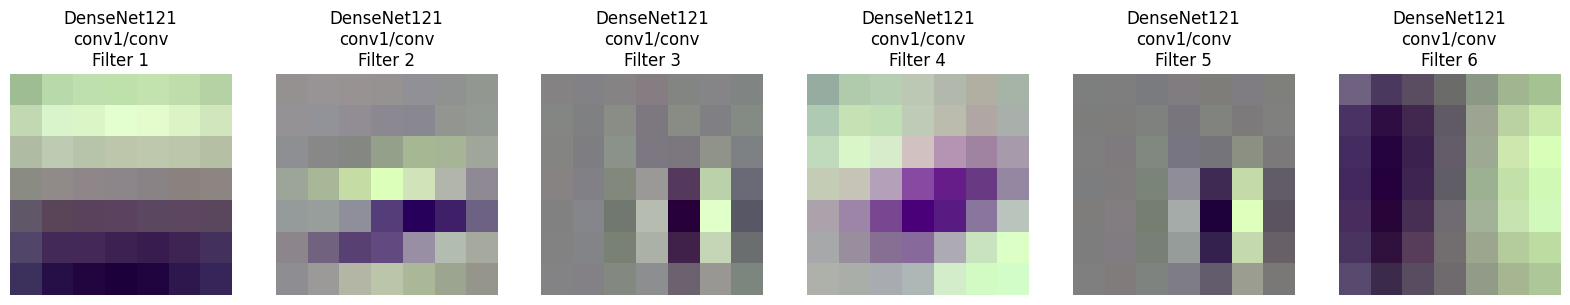

In [86]:
visualize_filters(model, 'DenseNet121')

Found DenseNet model: densenet121


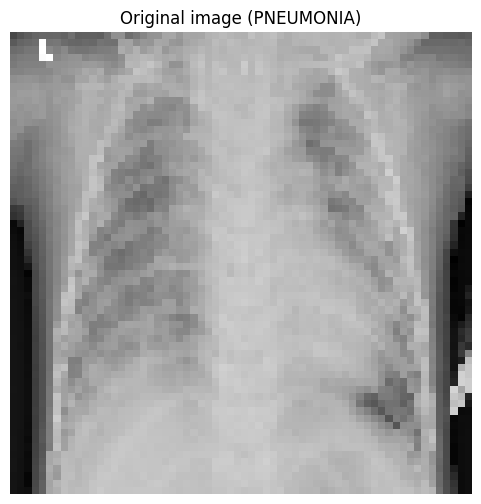

1/1 [==============================] - 0s 26ms/step


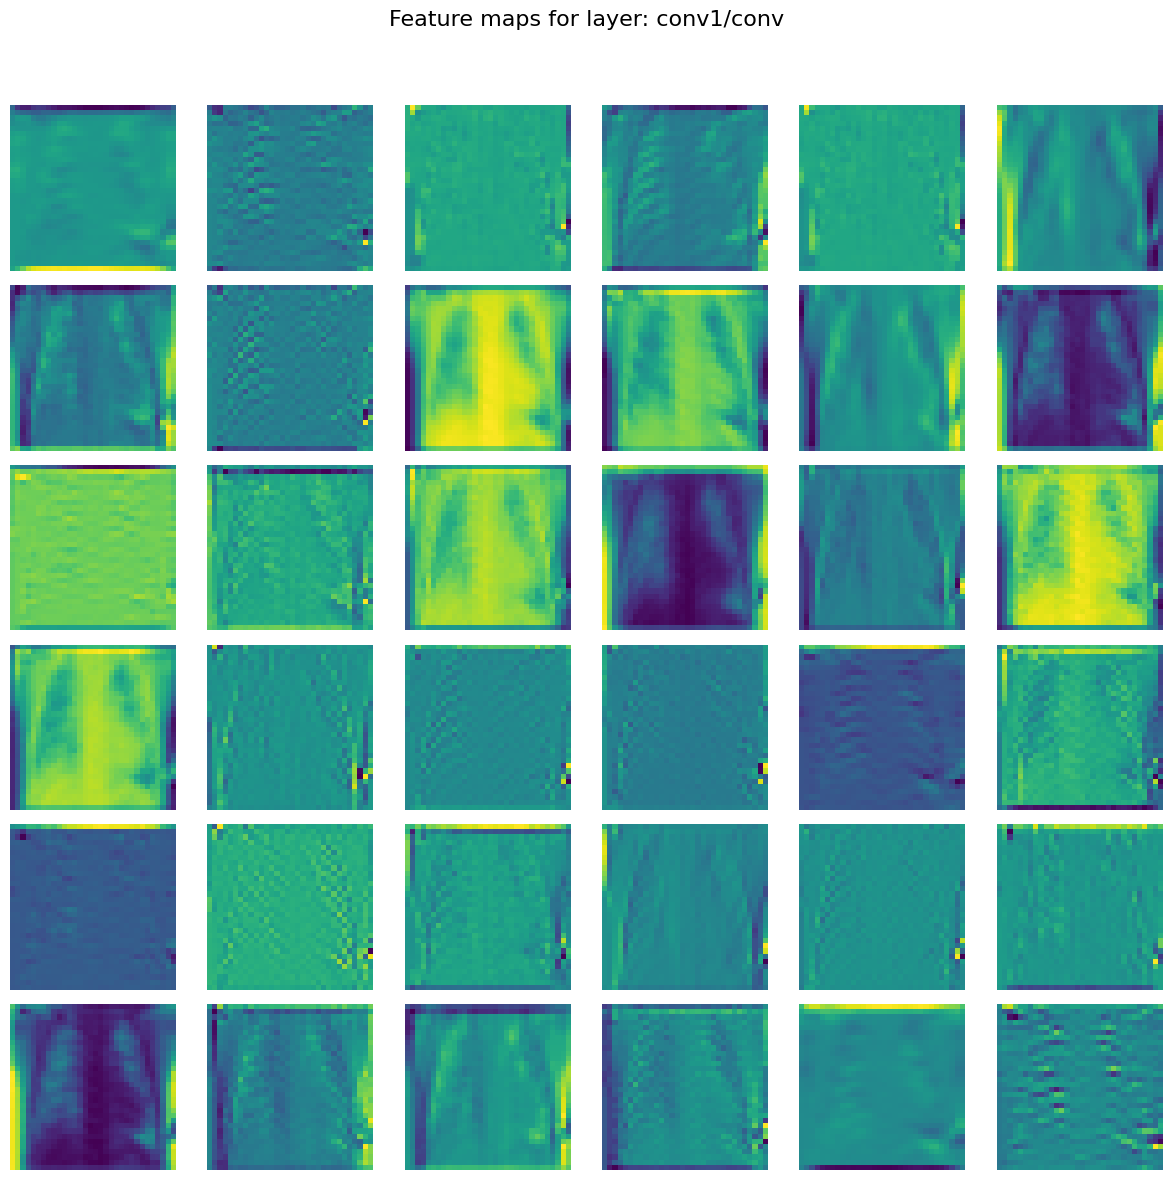

1/1 [==============================] - 0s 33ms/step


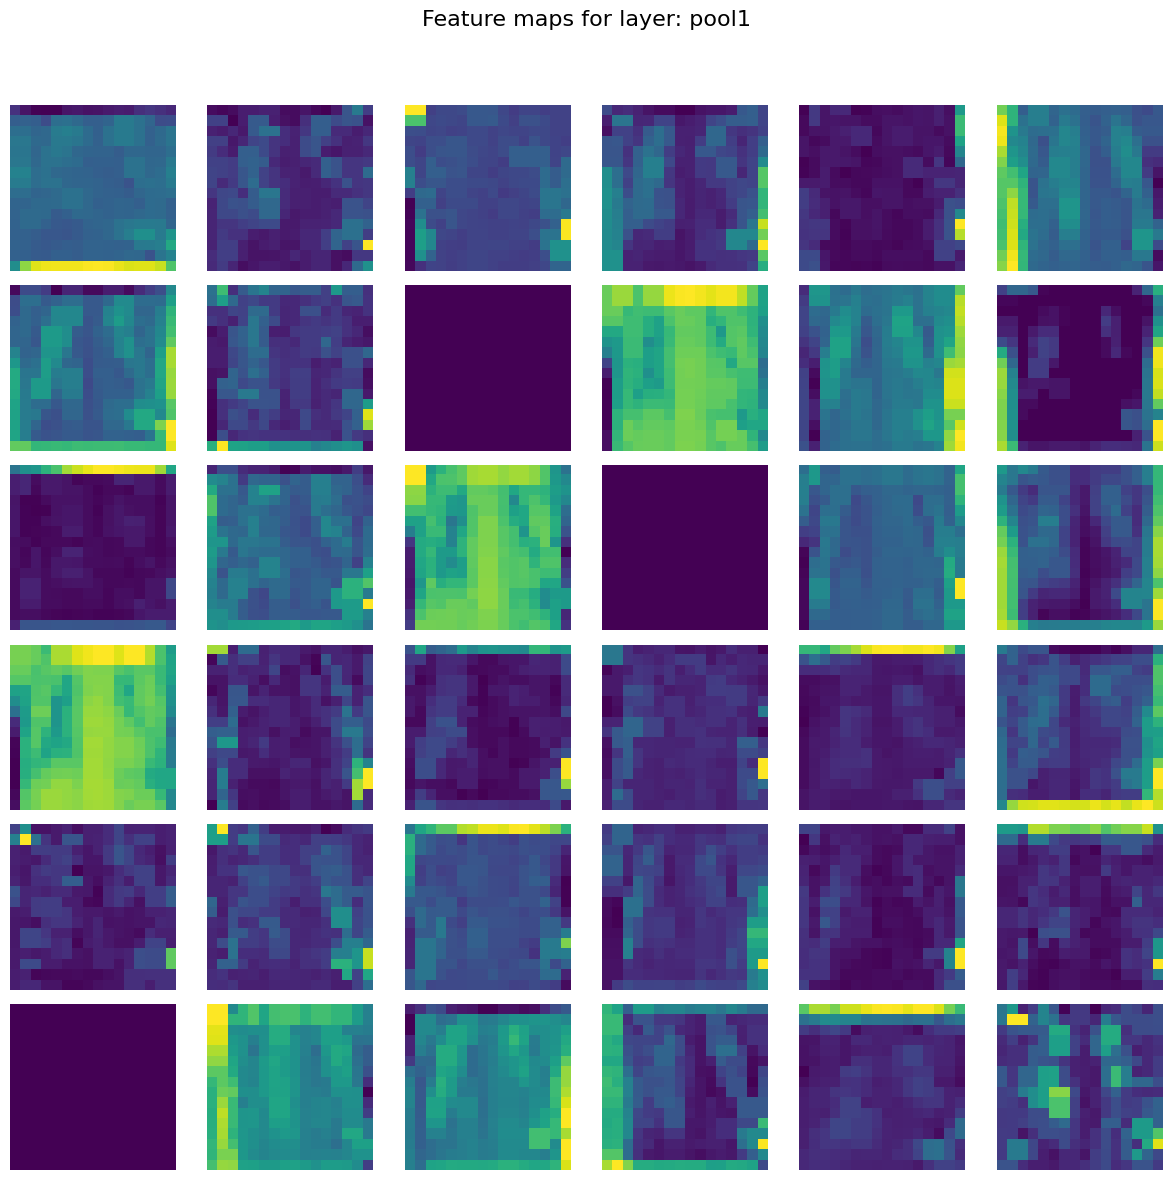

Found DenseNet model: densenet121


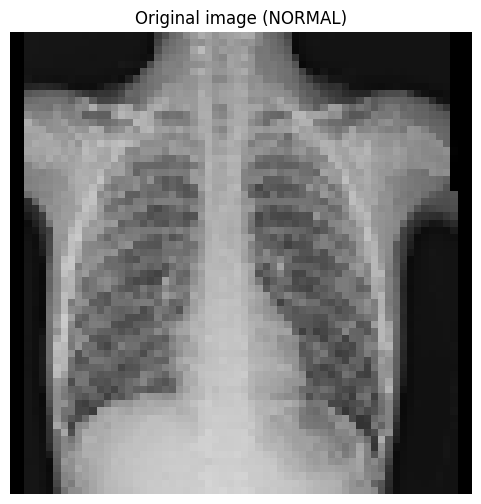

1/1 [==============================] - 0s 35ms/step


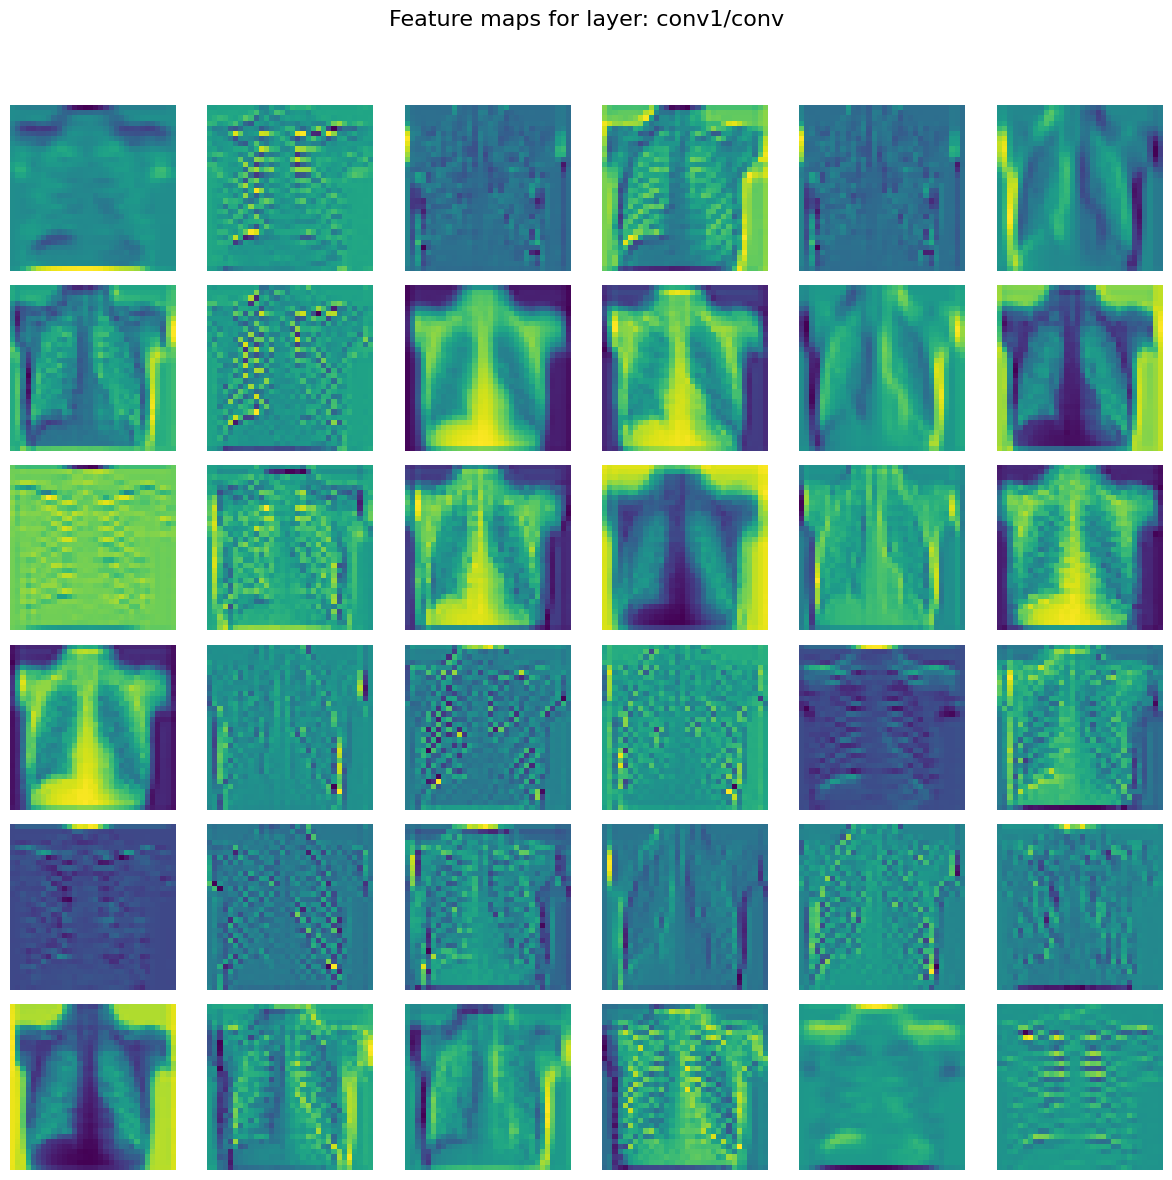

1/1 [==============================] - 0s 51ms/step


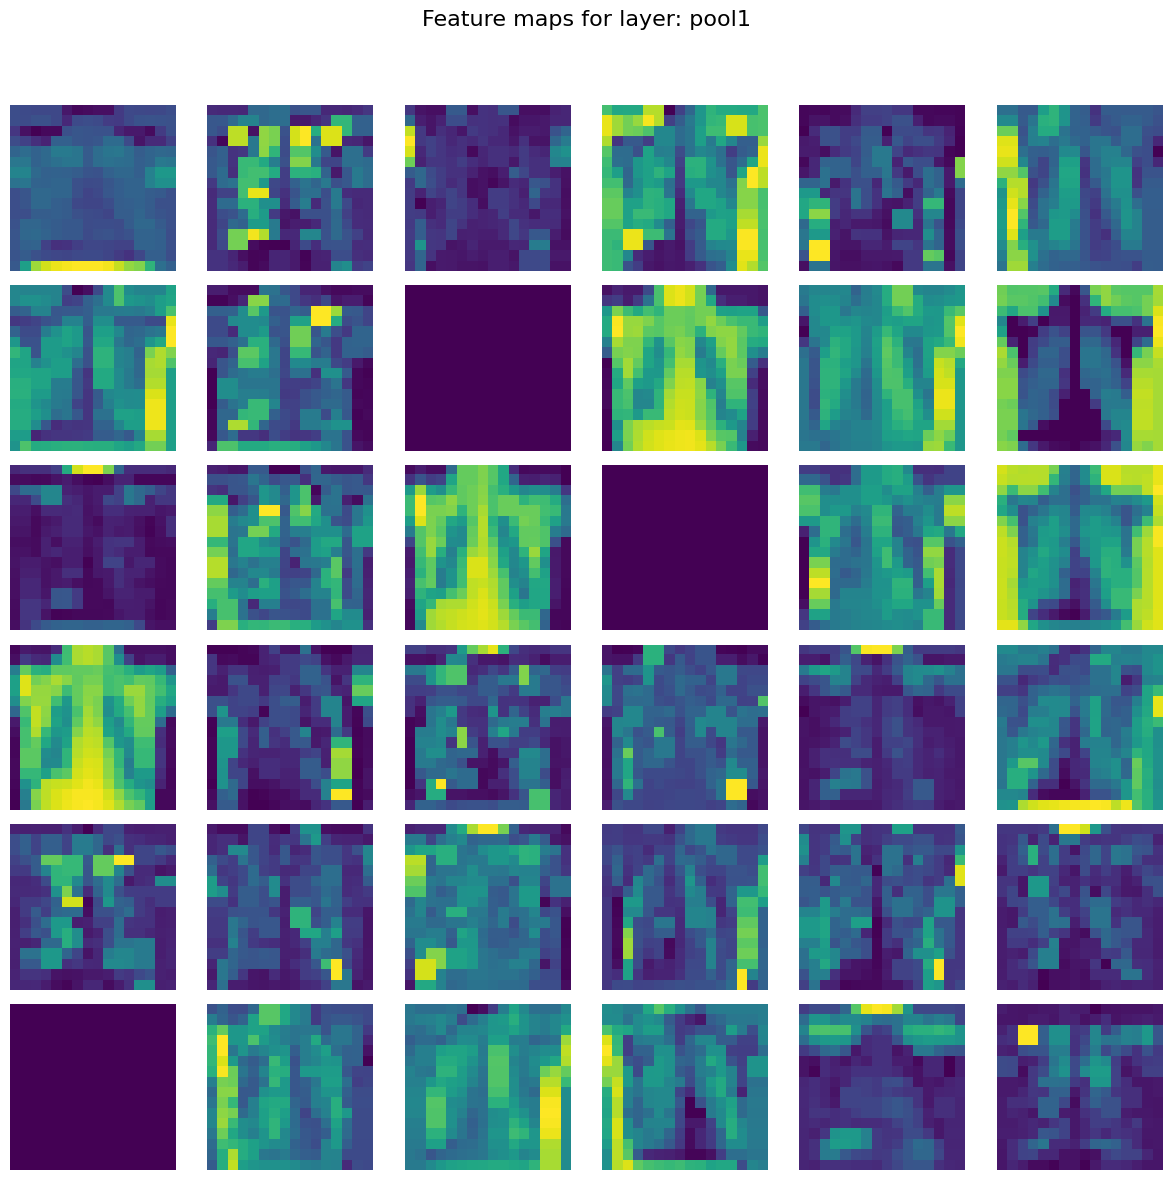

In [181]:
for type in ["PNEUMONIA", "NORMAL"]:
    sample_path = os.path.join(path, "test", type)
    samples = os.listdir(sample_path)

    if len(samples) > 0:
        visualize_densenet_activations(model, os.path.join(sample_path, samples[0]), type, img_size=(64, 64))
